# Лабораторная работа 1

Шутько Вадим Валерьвич. 2 Вариант.

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Вариант 2: задания 1 и 2 на наборе данных MNIST

Вариант 3: задания 1 и 3 на наборе данных CIFAR-10

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
digits = load_digits()

In [3]:
print(digits.data.shape)
print(digits.target.shape)

(1797, 64)
(1797,)


1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [4]:
def train_test(datasets, size=0.7):
    train = round(datasets.data.shape[0]*size)
    train = int(train)
    X_train, Y_train = datasets.data[:train], datasets.target[:train]
    X_test, Y_test = datasets.data[train:], datasets.target[train:]
    return X_train, Y_train, X_test, Y_test

In [5]:

X_train, y_train, X_test, y_test = train_test(digits)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (1258, 64)
Training labels shape:  (1258,)
Test data shape:  (539, 64)
Test labels shape:  (539,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



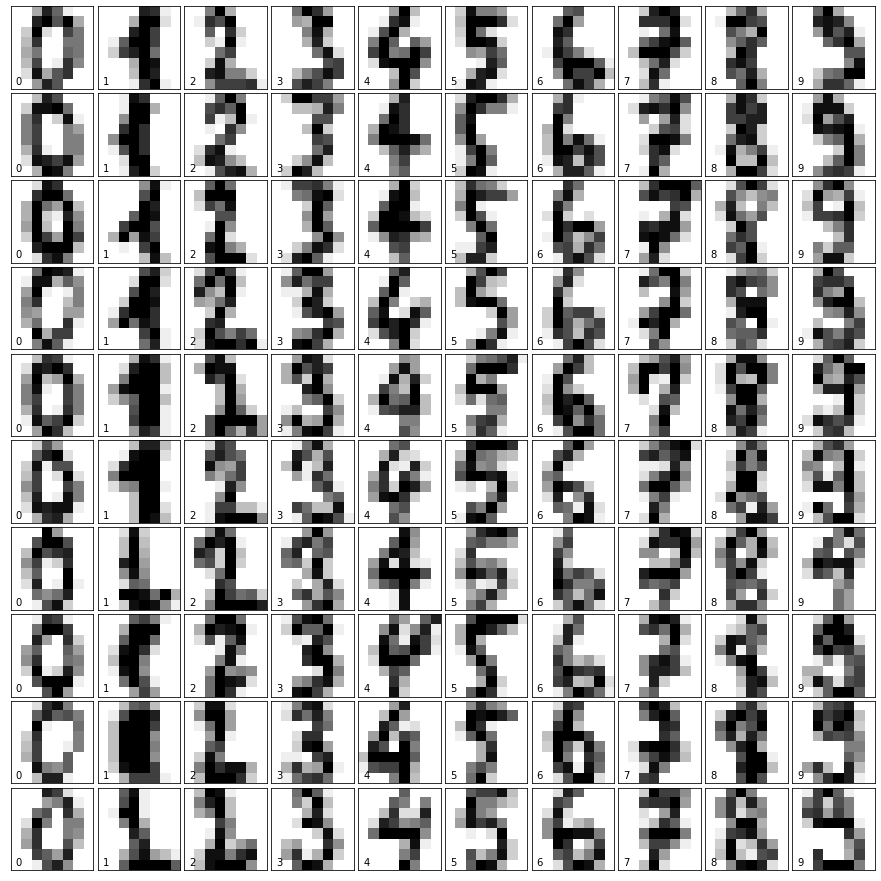

In [6]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# для отсортированного массива
# без сортировки просто X_train[i]
# y_train[i]
val = []
target = []
for i in range(10):
    val.append(X_train[y_train==i])
    target.append(y_train[y_train==i])

for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(val[i%10][i].reshape((8,8)), cmap=plt.cm.binary, interpolation='nearest')
    ax.text(0, 7, str(target[i%10][i]))

1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [7]:
from scripts.classifiers.k_nearest_neighbor import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [8]:
result = classifier.predict(X_test, k=3, num_loops=0)

1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


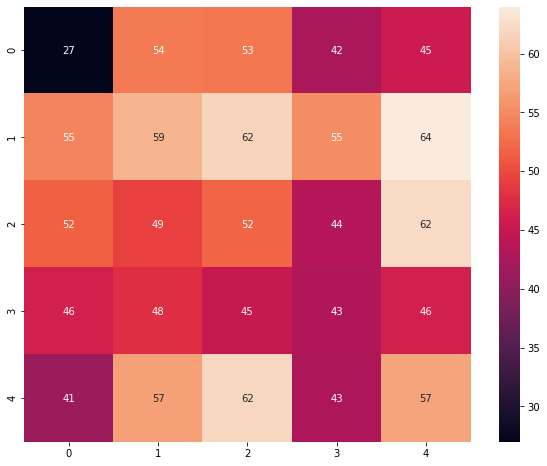

In [9]:
import seaborn as sns
sns.heatmap(classifier.dists[:5, :5], annot=True)


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [10]:
def accuracy_score(y, y_pred):
    return np.sum(y==y_pred)/y_pred.shape[0]
accuracy = accuracy_score(y_test, result)

In [11]:
accuracy

0.9703153988868275

1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

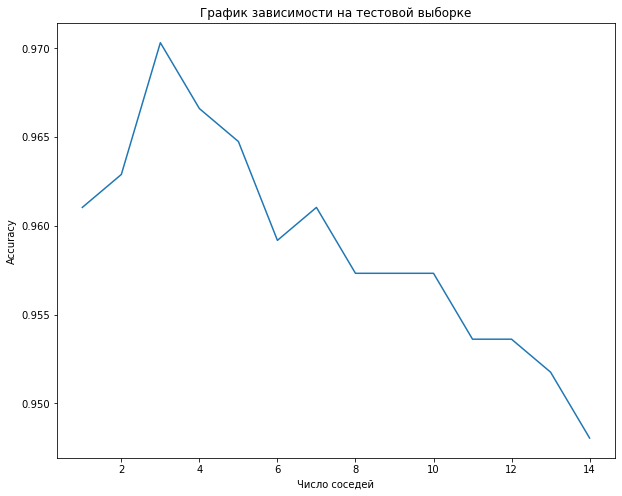

In [12]:
res = {}
for k in range(1,15):
    classifier.train(X_train, y_train)
    y_pred = classifier.predict(X_test, k=k, num_loops=0)
    res[k] = accuracy_score(y_test, y_pred)

plt.plot(list(range(1, 15)), list(res.values()))
plt.xlabel("Число соседей")
plt.ylabel("Accuracy")
plt.title("График зависимости на тестовой выборке")
plt.show()

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


Best accuracy 0.9671675013912076 on 3 neighbors


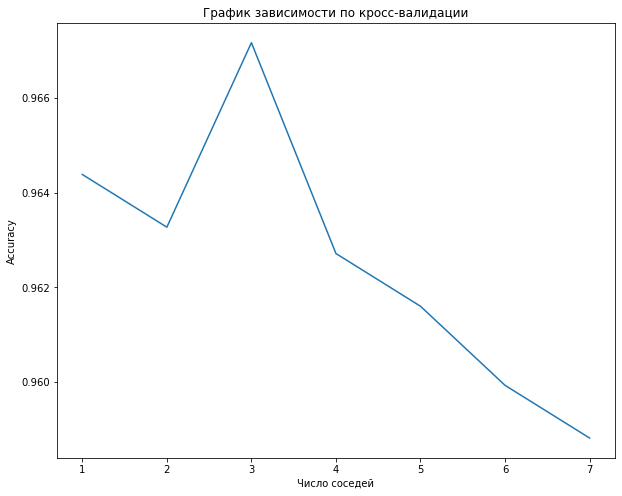

In [13]:
def cross_val_score(estimator, X, y,  cv=2, **kwargs):
    """
    Myself implementation of cross-validate
    estimator - object of classifier, example - KNN,
    X - data, numpy array,
    y - target, numpy array,
    k_neighbors - int,
    cv - int,
    Return: float - mean accuracy across all folds
    """

    result = []
    fold_data = np.array_split(X, cv)
    y = y.reshape(y.shape[0], 1) # ~hstack
    fold_target = np.array_split(y, cv)
    
    for fold in range(cv):
        X_test = fold_data[fold]
        y_test = fold_target[fold]
        y_test = y_test.reshape(y_test.shape[0], ) # ~hstack
        index = [x for x in range(cv) if x!=fold]
        b = np.array(fold_data)[index]
        c = np.array(fold_target)[index]
        X_train = np.vstack(b)
        y_train = np.vstack(c)
        y_train = y_train.reshape(y_train.shape[0], )
        estimator.train(X_train, y_train)
        y_pred = estimator.predict(X_test, **kwargs)
        result.append(accuracy_score(y_test, y_pred))
    return np.mean(result)
            
res = []
for k in range(1, 8):
    res.append(cross_val_score(classifier, digits.data, digits.target, 
                                cv=3, k=k, num_loops=0))       
accuracy_best, k_best = np.max(res), np.argmax(res)+1
print(f"Best accuracy {accuracy_best} on {k_best} neighbors")
plt.plot(range(1, 8), res)
plt.xlabel("Число соседей")
plt.ylabel("Accuracy")
plt.title("График зависимости по кросс-валидации")
plt.show()


1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.


In [14]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
result = classifier.predict(X_test, k = k_best, num_loops=0)
accuracy = accuracy_score(y_test, result)
print(accuracy)

0.9703153988868275


1.11 Сделайте выводы по результатам 1 части задания.

Лучшим соседом оказалось k=3

Векторная реализация подсчета куда быстрее реализаций с циклами, результаты при этом одинаковые

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [15]:
def train_val_test(datasets, size=(0.7, 0.2)):
    train, val = np.round(datasets.data.shape[0]*np.array(size))
    train, val = int(train), int(val)
    X_train, Y_train = datasets.data[:train], datasets.target[:train]
    X_val, Y_val = datasets.data[train:train+val], datasets.target[train:train+val]
    X_test, Y_test = datasets.data[train+val:], datasets.target[train+val:]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [16]:
X_train, y_train,  X_val, y_val, X_test, y_test = train_val_test(digits)

2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

[0.00000000e+00 2.79014308e-01 5.11287758e+00 1.16406995e+01
 1.18434022e+01 5.86168521e+00 1.51430843e+00 1.63751987e-01
 3.17965024e-03 1.93879173e+00]


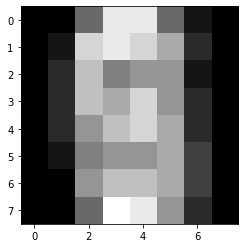

(1258, 65) (359, 65) (180, 65)


In [17]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow((mean_image.reshape((8,8))).astype('uint8')) 
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image



X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [18]:

from scripts.classifiers.linear_svm import svm_loss_naive
from scripts.classifiers.linear_svm import svm_loss_vectorized
import time


W = np.random.randn(65, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_train, y_train, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.993242



2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [19]:

loss, grad = svm_loss_naive(W, X_train, y_train, 0.0)

from scripts.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, X_train, y_train, 5e1)
f = lambda w: svm_loss_naive(w, X_train, y_train, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 7.687588 analytic: 7.687588, relative error: 5.333255e-11
numerical: -0.713987 analytic: -0.713987, relative error: 5.696585e-10
numerical: -0.182659 analytic: -0.182659, relative error: 1.285850e-09
numerical: -3.335562 analytic: -3.335562, relative error: 2.781770e-10
numerical: -1.655971 analytic: -1.655971, relative error: 1.722409e-10
numerical: -0.472196 analytic: -0.472196, relative error: 2.033965e-09
numerical: -2.300785 analytic: -2.300785, relative error: 4.272205e-11
numerical: 0.932822 analytic: 0.932822, relative error: 4.396955e-10
numerical: 0.010432 analytic: 0.010432, relative error: 3.850965e-08
numerical: 0.232483 analytic: 0.232483, relative error: 9.631628e-10
numerical: -0.003050 analytic: -0.003050, relative error: 2.219040e-07
numerical: -6.331688 analytic: -6.331688, relative error: 8.234775e-11
numerical: 0.003689 analytic: 0.003689, relative error: 7.207895e-09
numerical: -0.163345 analytic: -0.163345, relative error: 1.622963e-09
numerical: -1.20

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [20]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train, y_train, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.091005s
Vectorized loss and gradient: computed in 0.002003s
difference: 0.000000


2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [21]:
from scripts.classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 23.168429
iteration 100 / 1500: loss 14.154317
iteration 200 / 1500: loss 10.864695
iteration 300 / 1500: loss 9.658480
iteration 400 / 1500: loss 9.204676
iteration 500 / 1500: loss 9.044497
iteration 600 / 1500: loss 8.979869
iteration 700 / 1500: loss 8.961087
iteration 800 / 1500: loss 8.946487
iteration 900 / 1500: loss 8.946653
iteration 1000 / 1500: loss 8.945356
iteration 1100 / 1500: loss 8.948123
iteration 1200 / 1500: loss 8.951517
iteration 1300 / 1500: loss 8.942545
iteration 1400 / 1500: loss 8.948004
That took 0.456031s


In [22]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.870429
validation accuracy: 0.810585


In [23]:
y_test_pred = svm.predict(X_test)
print('test: %f' % (np.mean(y_test == y_test_pred), ))

test: 0.850000


2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [24]:
#  при 5e-5 улетим в бесконечность
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2.5e4, 5e4]

In [25]:
#y_train, y_val = y_train.reshape(y_train.shape[0], ), y_val.reshape(y_val.shape[0], )
X_svm_train = np.vstack((X_train, X_val))
y_svm_train = np.hstack((y_train, y_val))

In [26]:
def cross_val_score_svm(X, y,  cv=2, **kwargs):
    # опять говнокод
    """
    Myself implementation of cross-validate For svm
    X - data, numpy array,
    y - target, numpy array,
    cv - int,
    Return: float - mean accuracy across all folds
    """
    result = []
    fold_data = np.array_split(X, cv)
    y = y.reshape(y.shape[0], 1)
    fold_target = np.array_split(y, cv)
    
    for fold in range(cv):
        X_test = fold_data[fold]
        y_test = fold_target[fold]
        y_test = y_test.reshape(y_test.shape[0], ) # ~hstack
        index = [x for x in range(cv) if x!=fold]
        b = np.array(fold_data)[index]
        c = np.array(fold_target)[index]
        X_train = np.vstack(b)
        y_train = np.vstack(c)
        y_train = y_train.reshape(y_train.shape[0], )
        svm = LinearSVM()
        svm.train(X_train, y_train, **kwargs)
        y_pred = svm.predict(X_test)
        result.append(accuracy_score(y_test, y_pred))
    return np.mean(result)
            



In [27]:
svm = LinearSVM()
res = []
for learn in learning_rates:
    for reg in regularization_strengths:
        res.append(cross_val_score_svm(X_svm_train, y_svm_train, cv=5, learning_rate=learn, 
                                   reg=reg,
                                   num_iters=1500))

In [28]:
res

[0.8422963727401293,
 0.8429155677865687,
 0.8466269158735619,
 0.8379696517983412]

In [29]:
svm  = LinearSVM()
svm.train(X_svm_train, y_svm_train, learning_rate=1e-6, reg=2.5e4, num_iters=1500)
y_pred = svm.predict(X_test)
print('test: %f' % (np.mean(y_test == y_pred), ))

test: 0.877778


In [30]:
svm  = LinearSVM()
svm.train(X_train, y_train, learning_rate=1e-6, reg=5e4, num_iters=1500)
y_pred_val = svm.predict(X_val)
y_pred_test = svm.predict(X_test)
print('val: %f' % (np.mean(y_val == y_pred_val), ))
print('test: %f' % (np.mean(y_test == y_pred_test), ))

val: 0.807799
test: 0.827778


2.9 Сделайте выводы по второй части задания

Векторизованная версия подсчета фцнкции ошибки и градиентов быстрее обычной реализации. Аналитическое вычисление градиента совпадает с численным(расхождения в -10 степени). На качество обучения сильно влияют темп обучения, число итераций, а также константа регуляризации. При неправильно подобранном темпе обучения, функция ошибки улетает в бесконечность, accuracy- стремится к нулю
При выбранных параметрах на кросс-валидации, при обучении  на учебной и валидационной выборе, accuracy на тесте показывает наиболее высокий результат.
Многоклассовый свм уступает Knn